In [1]:
import numpy as np
from glob import glob
from skimage.io import imread
import matplotlib.pyplot as plt
from fishtrack.measurements import tail_angle
from fish.image.vol import dff
import peakutils as pk
from skimage.exposure import adjust_gamma
from scipy.ndimage.filters import median_filter, gaussian_filter
import pims
import pandas as pd
from pathlib import Path
from os.path import sep,split
from collections import OrderedDict

%matplotlib inline

In [2]:
def axs_format(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    
def make_composite_fish_image(raw, inset, scale, origin):
        from skimage.transform import resize
        inset = resize(inset, scale * np.array(inset.shape), preserve_range=True)
        raw[origin[0]:origin[0] + inset.shape[0], origin[1]:origin[1]+inset.shape[1]] = inset
    
        return raw, (*origin, *inset.shape)

In [3]:
exps = OrderedDict()

fs_im = 100
base_dir = '/groups/ahrens/ahrenslab/davis/data/epi/20170621/'

exp_dirs = list(Path(base_dir).iterdir())
exp_dirs.sort()

for expd in exp_dirs:
    exp_name = expd.parts[-1]
    raw_im_dir = expd / 'Pos0'
    mask_dir = expd / 'masks'
    if not mask_dir.exists():
        mask_dir = None
    aligned_fname = expd / (exp_name + '_aligned.tif')
    # we only work with experiments where the aligned images are saved
    if aligned_fname.exists():
        pos_params_fname = expd / (exp_name + '_position_data.npz')
        affine_params_fname = expd / 'regparams.npy'
        exps[exp_name] = {'raw_dir' : raw_im_dir, 
                          'aligned' : aligned_fname, 
                          'pos_params' : pos_params_fname, 
                          'affine_params_fname' : affine_params_fname,
                          'mask_dir' : mask_dir}
exp_names = list(exps.keys())
exps = pd.DataFrame(exps)

In [30]:
%%time
cur_exp = 0
col = exps.columns[cur_exp]
aligned_ims = pims.open(str(exps[col]['aligned']))
raw_ims = pims.ImageSequence(sorted(exps[col]['raw_dir'].glob('*.tif')))

/groups/ahrens/home/bennettd/anaconda3/lib/python3.5/site-packages/pims/api.py:191: UserWarning: <class 'pims.tiff_stack.TiffStack_tifffile'> errored: 'NoneType' object has no attribute 'TiffFile'
  warn(message)


CPU times: user 12.1 s, sys: 485 ms, total: 12.5 s
Wall time: 12.4 s


In [ ]:
exp = 5
pqim = pq.image(np.array(aligned_ims[exp]), title=exp_names[exp])

In [32]:
# when, frames, does the fish image stabilize
fish_onsets = [5890,1060,5740,1780,0,0,1200,0]
fish_onset = fish_onsets[cur_exp]

In [33]:
def tail_angle_wrapper(image, **kwargs):
    import fishtrack.measurements as meas
    return meas.tail_angle(np.array(image), **kwargs)

def get_events(data, thr_scale, duration):
    from fish.ephys.ephys import estimate_onset    
    thr = thr_scale * data.std() + np.median(data)
    events = estimate_onset(data, thr, duration=duration)
    
    return events

In [60]:
%%time
tail_angle = tail_angle_wrapper(aligned_ims, center=(100,200), radius=110)

CPU times: user 19.2 s, sys: 39.5 s, total: 58.7 s
Wall time: 58.7 s


In [35]:
%%time
# load some masks
from scipy.sparse import load_npz
masks = OrderedDict()
mask_dir = exps[col]['mask_dir']
if mask_dir is not None:        
    masks = [load_npz(f) for f in sorted(mask_dir.glob('*.npz'))]

CPU times: user 2min 1s, sys: 6.65 s, total: 2min 8s
Wall time: 2min 32s


In [36]:
tmp = np.array([m.toarray() for m in masks])
ts = np.abs(np.diff(tmp.astype('int8'), axis=0)).sum((1,2))

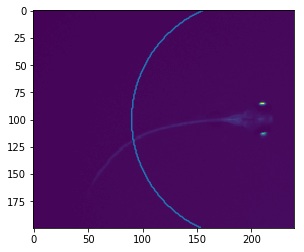

In [40]:
ind = 5
plt.imshow(aligned_ims[-1])
plt.plot(*tail_angle[1]);

In [41]:
%%time
# get rois means
from fishtrack.util import long_tail_threshold
# pick an ROI that's ~50% fish
roi = (slice(90,108), slice(170,194))   
roi_means = np.array([im_[roi][im_[roi] > np.median(im_[roi])].mean() for im_ in aligned_ims])

/groups/ahrens/home/bennettd/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice.
  """
/groups/ahrens/home/bennettd/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CPU times: user 10.9 s, sys: 11.3 s, total: 22.3 s
Wall time: 22.3 s


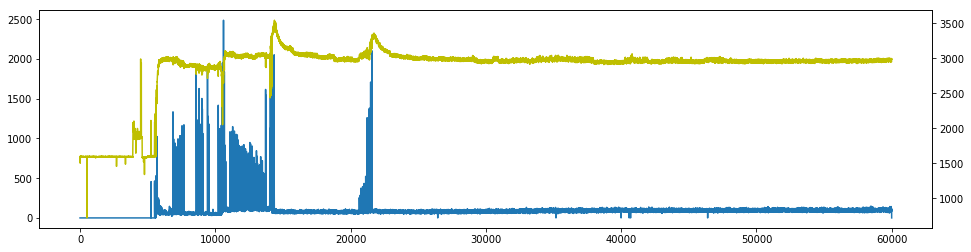

In [45]:
fig, axs = plt.subplots(figsize=(16,4), nrows=1, sharex=True)
axs.plot(ts)
axs.twinx().plot(roi_means,'y')

In [48]:
# make filtered baseline-normalized timeseries

from scipy.ndimage.filters import median_filter
dff_ = dff(median_filter(roi_means[fish_onsets[ind]:],size=10), window=2000, percentile=10, baseline_offset=.01, downsample=8)
# make a decaying exponential kernel
kw = 2000
tau  = 50
kern = np.exp(-np.arange(kw)/tau)
kern = np.concatenate([np.zeros(kern.shape), kern])
kern /= kern.sum()

from scipy.signal import convolve
smoothed_rois = convolve(dff_ - dff_.mean(), kern, mode='same') + dff_.mean()

In [50]:
# Make smoothed tail power timeseries
smoothed_tail_power = []
from scipy.signal import convolve
from numpy import diff
smoothed_tail_power = np.abs(diff(roi_means))

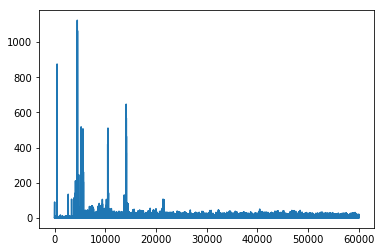

In [55]:
plt.plot(smoothed_tail_power)

In [ ]:
ind = 1
import fish.ephys.ephys as ep
from scipy.ndimage.filters import percentile_filter
signal = dff(roi_means[ind][plr], window=2000, downsample=8, baseline_offset=0, percentile=10)
signal = gaussian_filter(signal, sigma=100)
thr = 3 * signal.std() + np.median(signal)
fig, axs = plt.subplots(figsize=(16,3))
axs.plot(signal)
axs.axhline(thr)
events = ep.estimate_onset(signal, thr, duration=1500)
events = events[events > 10]
[axs.axvline(e, zorder=0, color='k') for e in events];

event_ind = 1
window = np.arange(-2000,2000)
fig, axs = plt.subplots(nrows=len(events), figsize=(9,3))
if len(events) ==1:
    axs=[axs]
for ind_e, ax in enumerate(axs):
    ax.plot(window, tail_angles[ind][0][plr][window + events[ind_e]])
    ax_2 = ax.twinx()
    ax_2.plot(window, signal[window + events[ind_e]], color='k')
    ax_2.axhline(thr)

In [4]:
def affine_rect(center, width, height, angle, axis, **kwargs):
    import numpy as np
    from matplotlib.transforms import Affine2D
    from matplotlib.patches import Rectangle
    
    center_ = np.array(center)
    # center the rectangle on the supplied center point    
    rect_origin = center_ - np.array([width/2, height/2])
    
    rect = Rectangle(rect_origin, width, height, **kwargs)
    # define a translation moving the 
    trans = Affine2D().translate(*-center_)
    rot = Affine2D().rotate_deg(angle)
    tx = trans + rot + trans.inverted() + axis.transData
    rect.set_transform(tx)
    
    return rect

In [5]:
example_fish = '6dpf_cy221xcy221_f2_spon_1'
fish_ims_al = pims.open(str(exps[example_fish]['aligned']))
fish_ims_raw = pims.ImageSequence(sorted(exps[example_fish]['raw_dir'].glob('*.tif')))
brain_pos = np.load(exps[example_fish]['pos_params'])['brain_centers']
affines = np.load(exps[example_fish]['affine_params_fname'])

fish_ind = 0

/groups/ahrens/home/bennettd/anaconda3/lib/python3.5/site-packages/pims/api.py:191: UserWarning: <class 'pims.tiff_stack.TiffStack_tifffile'> errored: 'NoneType' object has no attribute 'TiffFile'
  warn(message)


AttributeError: 'PosixPath' object has no attribute 'read'

/groups/ahrens/home/bennettd/anaconda3/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


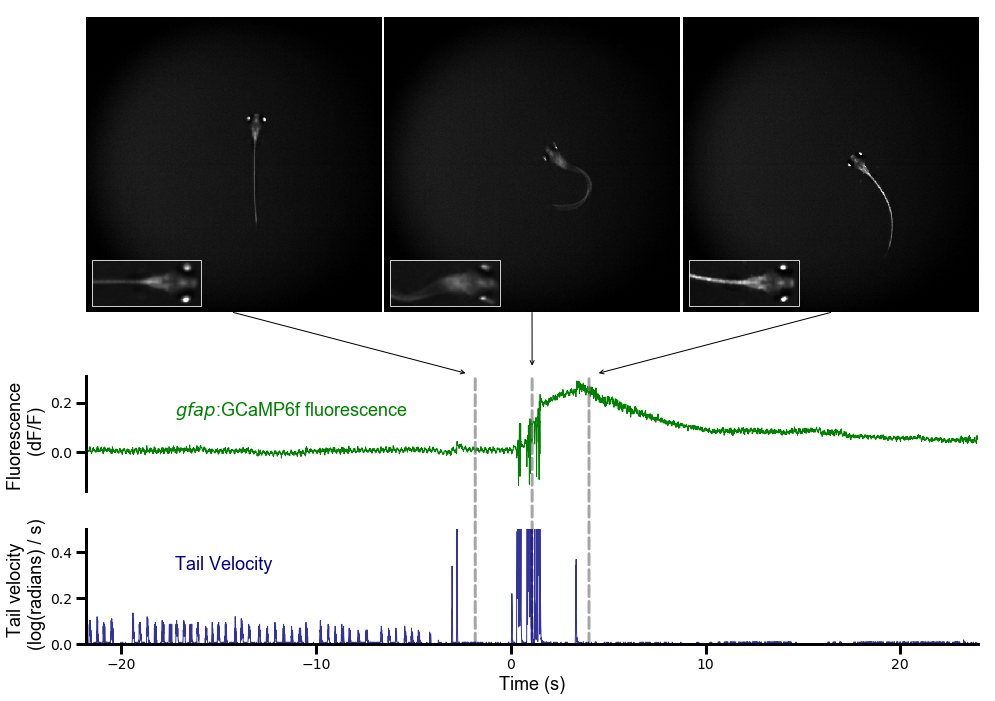

In [84]:
# Make sequence of images showing struggle and fluorescence
# use 6dpf_cy221xcy221_f2_spon_1_aligned.tif

from matplotlib.gridspec import GridSpec
from matplotlib.patches import ConnectionPatch, Rectangle
import matplotlib as mpl
label_size = 14
mpl.rcParams['font.serif'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['axes.linewidth'] = 3
mpl.rcParams['xtick.major.width'] = 3
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['ytick.major.width'] = 3
mpl.rcParams['ytick.major.size'] = 10

font = {'name' : 'Arial',
        'family': 'sans-serif',
        'weight': 'normal',
        'size': 18,
        }

tpoints = (13838, 14130, 14422)
colors = {'fl_ts':'g', 'tail_ts':'navy'}
roi = {}
roi['brain'] = (slice(min(tpoints)- 2000, max(tpoints) + 2000), slice(94, 104), slice(190, 194))
x_axis = (np.arange(roi['brain'][0].start, roi['brain'][0].stop)) / fs_im
struggle_time = 140.2
x_axis -= struggle_time

fig = plt.figure(figsize=(16,12))
gs = GridSpec(nrows=3, ncols=3, height_ratios=(3,1,1))
axs_ims = []

# set the clim based on the brain fluorescence, not the eyes
# x position before eyes appear in image
eye_cutoff = 200
crop = 10
clim = min([fish_ims_al[t][crop:-crop, crop:-crop].min() for t in tpoints]), max([fish_ims_al[t][crop:-crop, crop:eye_cutoff].max() for t in tpoints])

# show fish images
for ind, t in enumerate(tpoints):
    axs_ims.append(fig.add_subplot(gs[0,ind]))
    raw = fish_ims_raw[t].copy()
    inset = fish_ims_al[t].copy()[80:120,130:225]
    scale = 2
    ori = (10,10)
    composite, bbox = make_composite_fish_image(raw, inset, scale, ori)
    inset_border = Rectangle(bbox[:2][::-1], bbox[3], bbox[2], fill=False, color='white', linewidth=1, alpha=.8)
    axs_ims[-1].imshow(composite, cmap='gray', clim=clim, origin='lower')
    axs_ims[-1].add_patch(inset_border)
    axs_ims[-1].axis('off')
    for key, val in roi.items():
        patch = Rectangle((val[2].start, val[1].start), 
                 val[2].stop - val[2].start, 
                 val[1].stop - val[1].start, fill=False, color='r', linestyle='-', linewidth=2)
        # don't add the patch until I can properly orient it relative to the moving fish brain
        # axs_ims[-1].add_patch(patch)

axs_ts = []
axs_ts.append(fig.add_subplot(gs[1,:]))
axs_ts.append(fig.add_subplot(gs[2,:]))
fl_ts = np.array(fish_ims_al[roi['brain'][0]])[:,roi['brain'][1],roi['brain'][2]].mean((1,2))
fl_ts = dff(fl_ts, 100 * fs_im, 10, baseline_offset=10)
axs_ts[0].plot(x_axis, fl_ts, color=colors['fl_ts'], linewidth=1)
axs_ts[0].set_ylabel('Fluorescence \n (dF/F)', fontdict=font)
axs_ts[0].annotate('$\itgfap$:GCaMP6f fluorescence', (.1,.65), xycoords='axes fraction',color=colors['fl_ts'], fontsize=18, fontname='Arial')

tail_ts = np.log(1 + np.abs(np.diff(tail_angle[0][roi['brain'][0]])))
axs_ts[1].plot(x_axis[1:], tail_ts, alpha=.8, color=colors['tail_ts'], linewidth=1)
axs_ts[1].set_ylim(0,.5)
axs_ts[1].set_ylabel('Tail velocity \n (log(radians) / s)', fontdict=font)
axs_ts[1].annotate('Tail Velocity', (.1,.65), xycoords='axes fraction',color=colors['tail_ts'], fontsize=18, fontname='Arial')

axs_ts[1].set_xlabel('Time (s)', fontdict=font)
axs_format(axs_ts[1])
axs_format(axs_ts[0])
list(map(axs_format, axs_ts))
[ax.set_xlim(x_axis[0], x_axis[-1]) for ax in axs_ts]
axs_ts[0].spines['bottom'].set_visible(False)

# Draw dotted lines for the sampled timepoints
for ind, t in enumerate(tpoints):
    xyA = (x_axis[(t - roi['brain'][0].start)], axs_ts[1].get_ylim()[0])
    xyB = (x_axis[(t - roi['brain'][0].start)], axs_ts[0].get_ylim()[-1])
    coordsA = "data"
    coordsB = "data"
    con = ConnectionPatch(xyA=xyA, xyB=xyB, coordsA=coordsA, coordsB=coordsB,
                      axesA=axs_ts[1], axesB=axs_ts[0],shrinkB=0,color='grey', linestyle='--', alpha=.7, linewidth=3)
    axs_ts[1].add_artist(con)

# erase x-axis for top timeseries plot
axs_ts[0].tick_params(
    axis='x',
    which='both',
    bottom='off',
    top='off',
    labelbottom='off')

# Stick connecting lines between images and timeseries
for ind, t in enumerate(tpoints):
    xyA = (.5,0)
    xyB = (x_axis[(t - roi['brain'][0].start)], axs_ts[0].get_ylim()[-1])
    coordsA = "axes fraction"
    coordsB = "data"
    con = ConnectionPatch(xyA=xyA, xyB=xyB, coordsA=coordsA, coordsB=coordsB,
                      axesA=axs_ims[ind], axesB=axs_ts[0],
                      arrowstyle="->", shrinkB=10)

    axs_ims[ind].add_artist(con)

plt.subplots_adjust(wspace=.01)
plt.savefig('/groups/ahrens/ahrenslab/projects/ngm/presentation/resource/{0}_struggle_example.pdf'.format(example_fish))